# SHAP: Understanding the Functioning of an ML-based (XGBoost) with new data : Habitable or Non-Habitable Exoplanet

### Setting the Environment

Pour utiliser toutes les librairies qui suivent, il faut avoir une ancienne version de sklearn. On va donc vérifier que l'on a la 1.5.0, et sinon on réinstalle la bonne version. Il faudra ensuite relancer la session.

In [1]:
import sklearn
if sklearn.__version__ != "1.5.0":
    print(sklearn.__version__)
    print("La version de sklearn doit être vers les 1.5.0 pour que la suite fonctionne")
    print("Re-installation de sklearn en 1.5.0...")
    !pip install scikit-learn==1.5.0 --quiet
    !pip show scikit-learn
    print("La session doit être redemarrer !")
else:
    print(sklearn.__version__)
    print(f"Bonne version !")

1.5.0
Bonne version !


In [2]:
import sys
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", size=16)

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn import model_selection

On importe les données d'exoplanètes : ATTENTION ! il faut changer cette partie si vous n'etes pas sur google drive ou autre ...

In [3]:
url = "https://raw.githubusercontent.com/AngeloLF/M2_MALIA_XAI/refs/heads/main/data/hws.csv" # si pas dispo assez sur https://phl.upr.edu/hwc/data, ou sur le github https://github.com/AngeloLF/M2_MALIA_XAI
df = pd.read_csv(url)
df = df.dropna(subset=["P_TEMP_SURF"]) # On supprime les observations où la colonne *P_TEMP_SURF* est en NaN, cf. rapport.

x = df.drop(columns=["P_HABITABLE", "P_HABZONE_OPT"]) #, "P_ESI"])  # Supprimer la colonne cible (et *P_HABZONE_OPT*, cf. rapport). On peut aussi tout refaire en retirant "P_ESI"
x = x.select_dtypes(exclude=["object"])
y = df["P_HABITABLE"]
x.describe()

,P_YEAR,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_MASS_LIMIT,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_RADIUS_LIMIT,P_PERIOD,...,S_HZ_CON_MAX,S_HZ_CON0_MIN,S_HZ_CON0_MAX,S_HZ_CON1_MIN,S_HZ_CON1_MAX,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_CON,P_ESI
count,2441.000000,2441.000000,446.000000,446.000000,2441.000000,2441.000000,2057.000000,2057.000000,2441.00000,2441.000000,...,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2.441000e+03,2441.000000,2441.000000,2441.000000
mean,2016.745596,6.543668,-4.035822,5.290724,0.029906,1.706256,-0.227206,0.312168,-0.00041,16.473488,...,1.443535,0.859350,1.443535,0.784327,1.443535,2.293668,3.155857e+13,0.417394,0.017206,0.326060
std,2.973036,37.031091,18.659794,24.399729,0.172751,0.525431,0.519760,1.603470,0.02024,32.885827,...,0.852208,0.520838,0.852208,0.475723,0.852208,1.451423,1.102293e+15,0.065566,0.130065,0.110138
min,2004.000000,0.130000,-344.700000,0.000000,-1.000000,0.460000,-21.320000,0.011000,-1.00000,0.179719,...,0.049840,0.026123,0.049840,0.023760,0.049840,0.063513,3.648381e-03,0.142824,0.000000,0.202823
25%,2014.000000,2.300000,-1.700000,0.440000,0.000000,1.300000,-0.240000,0.100000,0.00000,3.886895,...,0.858553,0.498122,0.858553,0.453893,0.858553,1.267254,2.892909e-01,0.382543,0.000000,0.273569
50%,2016.000000,3.610000,-0.840000,0.810000,0.000000,1.670000,-0.140000,0.184000,0.00000,8.010943,...,1.285783,0.763500,1.285783,0.696751,1.285783,2.010776,1.083487e+00,0.438235,0.000000,0.291352
75%,2019.000000,5.520000,-0.430000,1.800000,0.000000,2.130000,-0.090000,0.340000,0.00000,16.007583,...,1.973772,1.186171,1.973772,1.082949,1.973772,3.208956,2.225305e+00,0.455980,0.000000,0.317429
max,2024.000000,1303.000000,0.000000,419.100000,1.000000,7.100000,-0.005000,68.910000,0.00000,636.130000,...,7.251734,4.440556,7.251734,4.057128,7.251734,12.923012,3.851723e+16,0.610750,1.000000,0.968362


In [4]:
# La colonne *P_HABITABLE* a en rélatité trois valeurs : 0 pour Non-Habitable, et 1 et 2 pour différentes "varientes" de Habitable ("conservative" et "optimistic", cf. rapport)
# On renvoie donc tout les 2 en 1 pour former que deux option : 0 pour Non-Habitable et 1 pour Habitable.
print(np.unique(y.values, return_counts=True))
y[y == 2] = 1
print(np.unique(y.values, return_counts=True))

(array([0, 1, 2]), array([2371,   29,   41]))
(array([0, 1]), array([2371,   70]))


**Target Distribution**


- Habitable : **1**

- Non-Habitable : **0**

<Axes: ylabel='P_HABITABLE'>

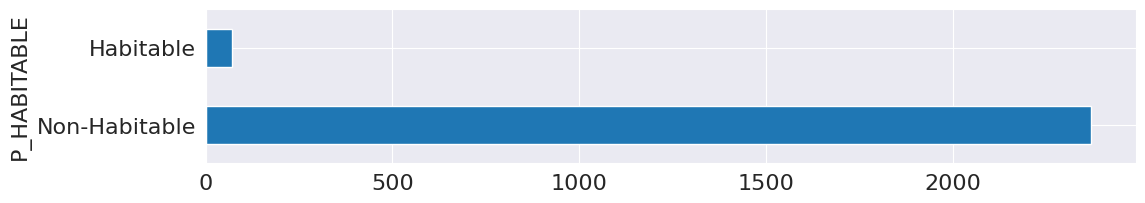

In [5]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12, 2))
counter = y.value_counts()
counter.rename(index={1.0: "Habitable", 0.0: "Non-Habitable"}, inplace=True)
ax.set_xlabel("# Cases", size=16)
counter.plot(kind="barh", ax=ax)

In [6]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
proportion_class = counter["Non-Habitable"] / counter["Habitable"]

params_xgb = {
    "n_estimators": 200,
    "max_depth": 8,
    "learning_rate": 0.05,
    "scale_pos_weight": proportion_class
}

xgb = XGBClassifier(**params_xgb, use_label_encoder=True)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Text(0.5, 1.0, 'Confusion Matrix (Train set)')

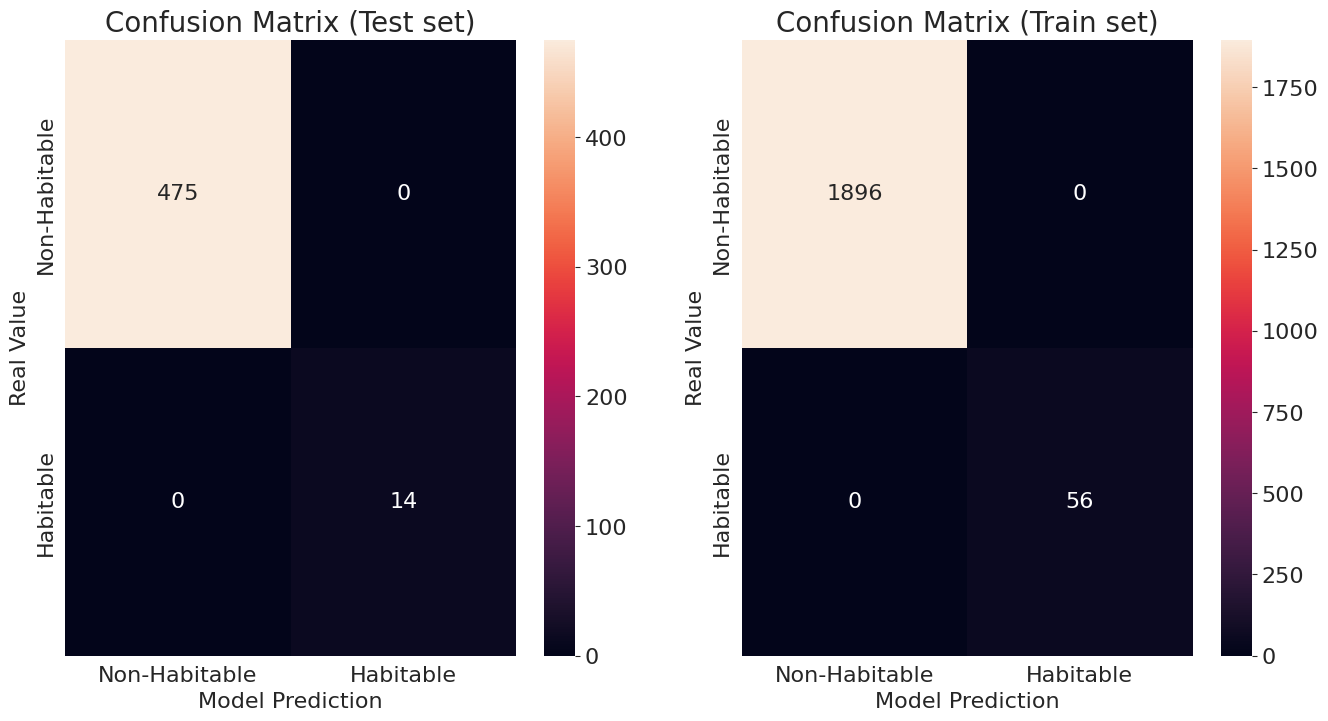

In [8]:
y_hat = xgb.predict(x_test)
cf = metrics.confusion_matrix(y_pred=y_hat, y_true=y_test)
cf_train = metrics.confusion_matrix(y_pred=xgb.predict(x_train), y_true=y_train)
names_df = [
    "Non-Habitable",
    "Habitable"
]
cf_df = pd.DataFrame(data=cf, columns=names_df, index=names_df)
cf_train_df = pd.DataFrame(data=cf_train, columns=names_df, index=names_df)
fig, ax = plt.subplots(ncols=2, figsize=(16,8))

sns.heatmap(cf_df, fmt="d",annot=True, ax=ax[0])
ax[0].set_xlabel("Model Prediction", size=16)
ax[0].set_ylabel("Real Value", size=16)
ax[0].set_title("Confusion Matrix (Test set)", size=20)

sns.heatmap(cf_train_df, fmt="d",annot=True, ax=ax[1])
ax[1].set_xlabel("Model Prediction", size=16)
ax[1].set_ylabel("Real Value", size=16)
ax[1].set_title("Confusion Matrix (Train set)", size=20)

## SHAP Values

Now we are going to use what we learnt from the SHAP values to understand how our model works. We use the framework developed by Lundberg et al. https://github.com/slundberg/shap

In [9]:
#Run if shap not installed
! pip install shap

In [10]:
import shap

**We are going to explain the xgboost model. Since the model developed previously is a tree based we are going to use Tree explainer, a fast implementation to compute Shap values when models are tree based**

In [11]:
explainer = shap.TreeExplainer(xgb, x, model_output = "raw")
shap_values = explainer.shap_values(x)

**Local interpretability: How do we interpret the SHAP force plot?**


The value we observe in bold is the natural logarithm of the odd ratio $ln(\frac{P(Y=1)}{1-P(Y=1)})$. The base value is the odd ratio if we just consider the number of positive cases over the total of instances. The Shapley values can be understood as forces that push the output of the model. Forces of Shapley values in blue represent the features that increase the probability of default, while red values represent the features that are incrementing the probability of having a habitable exoplanet.

In [12]:
shap.initjs()
index = 125
print(y.iloc[index])
shap.force_plot(explainer.expected_value, shap_values[index,:], x.iloc[index,:])

1


**Global interpretability: SHAP Summary plot.**

The SHAP summary plot allows us to understand the model by ranking the features from the most relevant to the least important ones. Each datapoint represents a different person. In this concrete use case, the most relevant feature are: the variation of the activity mesasurements obtained of the actigraph watch, the Montgomery Asberg Depression Rating Scale at the moment the actigraph was stopped. High values of these features impact negatively in the output of the model (the probability of having a habitable exoplanet increases).

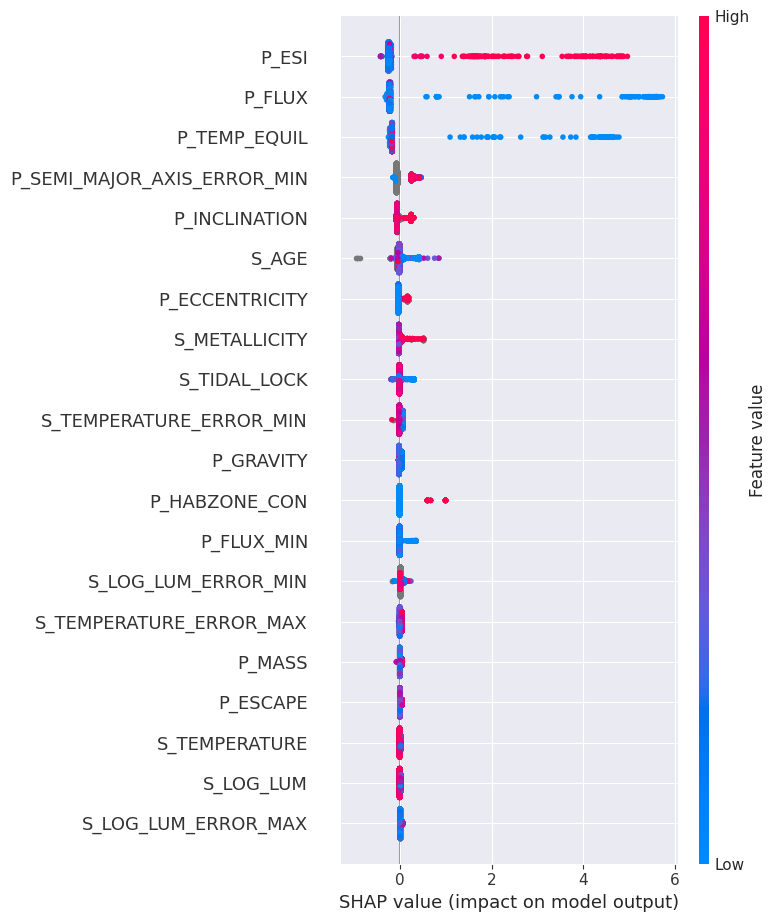

In [13]:
shap.summary_plot(shap_values, x, show=False)

plt.savefig("shap_summary_plot.png", bbox_inches="tight")